In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Rio Grande Do Sul - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_RS.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,0.701216,135.543840,188.093,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,0.701343,134.468148,170.973,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,0.701470,134.242963,174.880,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,0.701596,133.169391,178.111,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,0.701723,132.046874,184.331,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


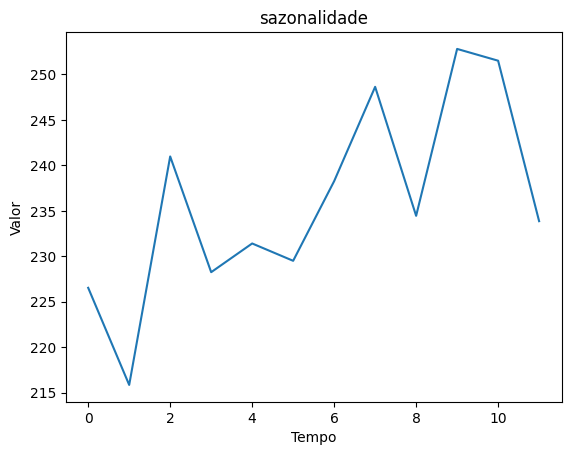

,sazonalidade
sazonalidade,
0,226.535776
1,215.861829
2,240.974809
3,228.253307
4,231.409887
5,229.504290
6,238.259767
7,248.628280
8,234.449571


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande do Sul - IDH Educacao,Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - PIB - Estadual,Rio Grande do Sul - PIB - Construção Civil,Rio Grande do Sul - PIB - Per Capita,Rio Grande do Sul - PIB - Preços de Mercado,Rio Grande do Sul - IDH Longevidade,Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio Grande do Sul - IDH,sazonalidade,Rio Grande Do Sul - Consumo de Cimento (t)
0,2003-1,8.192273,2.046281e+07,0.813273,2.335964,1008.041778,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,0.701216,135.543840,2.066295e+08,8.907130e+06,18.206952,1.960625e+08,0.834825,0.399576,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.775641,226.535776,188.093
1,2003-2,8.186359,2.051916e+07,0.812953,2.025977,1008.772431,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,0.701343,134.468148,2.068579e+08,8.912326e+06,18.211286,1.961183e+08,0.835136,0.398811,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.775686,215.861829,170.973
2,2003-3,8.180446,2.057551e+07,0.812634,1.829198,1009.718901,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,0.701470,134.242963,2.070864e+08,8.917522e+06,18.215621,1.961742e+08,0.835447,0.397898,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.775731,240.974809,174.880
3,2003-4,8.174533,2.063185e+07,0.812315,1.686795,1010.889835,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,0.701596,133.169391,2.073148e+08,8.922718e+06,18.219955,1.962300e+08,0.835759,0.397042,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.775775,228.253307,178.111
4,2003-5,8.168619,2.068820e+07,0.811996,1.685569,1012.010849,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,0.701723,132.046874,2.075433e+08,8.927915e+06,18.224290,1.962858e+08,0.836070,0.396050,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.775820,231.409887,184.331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37348.455735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231.409887,NaN
269,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37320.998188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229.504290,NaN
270,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37269.070370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.259767,NaN
271,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37194.272320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.628280,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      168.412
1      153.593
2      166.196
3      150.226
4      154.220
        ...   
268        NaN
269        NaN
270        NaN
271        NaN
272        NaN
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 273, dtype: float64

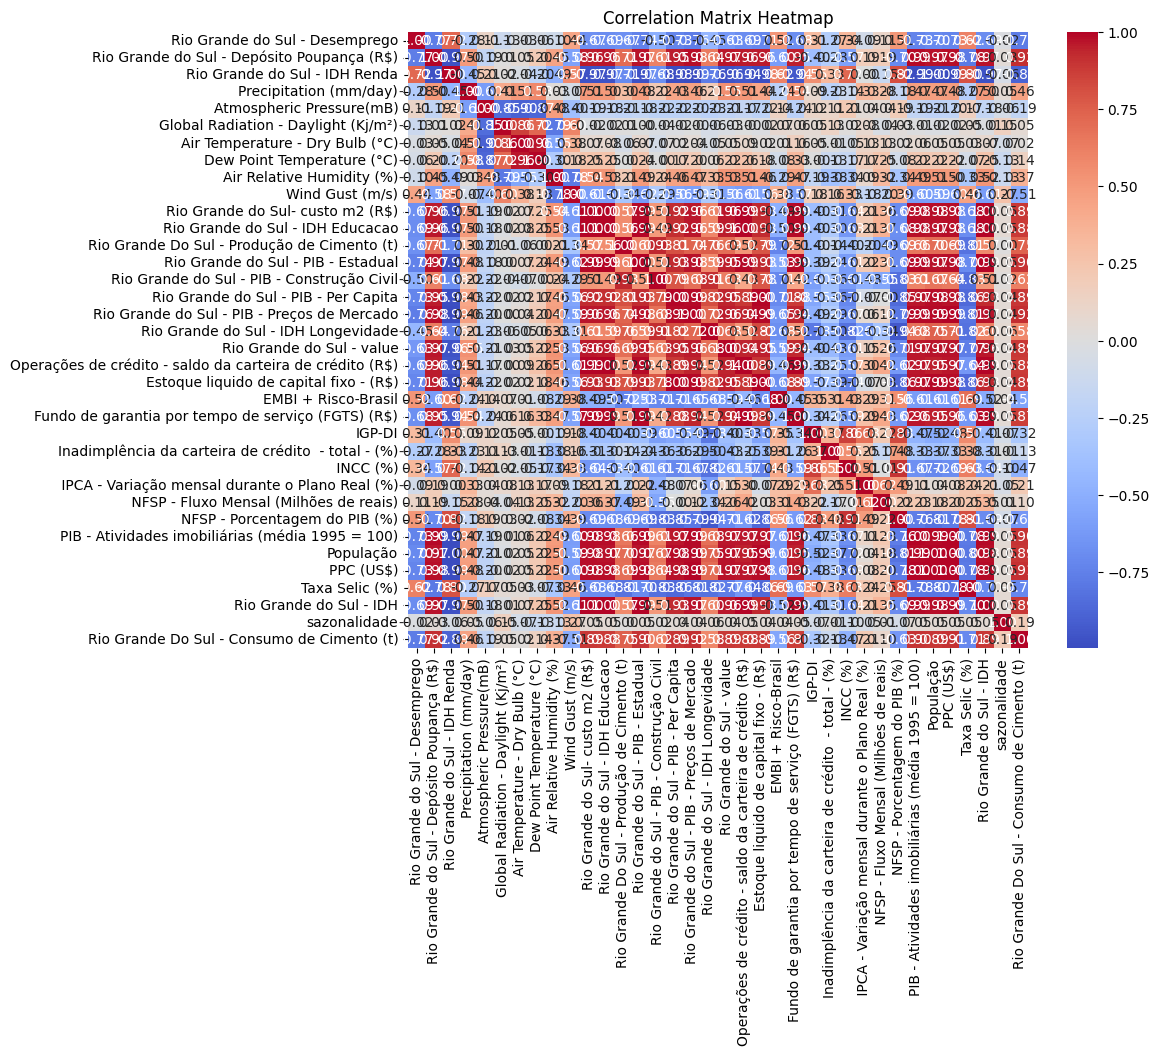

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio Grande do Sul - Desemprego,1.619375e+03
1,Rio Grande do Sul - Depósito Poupança (R$),2.826031e+03
2,Rio Grande do Sul - IDH Renda,2.815981e+05
3,Precipitation (mm/day),5.797350e+00
4,Atmospheric Pressure(mB),5.443881e+01
5,Global Radiation - Daylight (Kj/m²),7.095642e+01
6,Air Temperature - Dry Bulb (°C),1.034949e+04
7,Dew Point Temperature (°C),7.674378e+03
8,Air Relative Humidity (%),1.052415e+03
9,Wind Gust (m/s),1.662070e+01


In [39]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' NFSP - Fluxo Mensal (Milhões de reais)',
                 'Air Temperature - Dry Bulb (°C)', 
                 'Dew Point Temperature (°C)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Rio Grande do Sul - Desemprego,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,8.192273,2.046281e+07,0.813273,2.335964,1362.096101,22.905299,17.235207,72.391106,1.662459,11314.228000,135.543840,0.399576,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,226.535776
1,8.186359,2.051916e+07,0.812953,2.025977,1279.483110,22.138294,16.659273,72.991721,1.632484,11415.287231,134.468148,0.398811,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,215.861829
2,8.180446,2.057551e+07,0.812634,1.829198,1152.849514,20.909949,15.838093,74.540195,1.615540,11510.305379,134.242963,0.397898,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,240.974809
3,8.174533,2.063185e+07,0.812315,1.686795,1019.807364,19.370371,14.523610,75.365237,1.576371,11603.969307,133.169391,0.397042,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,228.253307
4,8.168619,2.068820e+07,0.811996,1.685569,969.329735,17.963807,13.249924,75.732130,1.558359,11692.135859,132.046874,0.396050,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,231.409887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,7.678324,3.486916e+07,0.779938,1.930780,1008.605970,18.899893,14.879298,79.438701,1.417069,22927.092159,140.385172,0.591971,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,248.628280
152,7.677515,3.477586e+07,0.779246,1.821841,1055.681875,19.363969,15.497829,80.105382,1.465741,23034.488593,139.462066,0.592084,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,234.449571
153,7.676706,3.468255e+07,0.778554,2.066079,1152.279988,20.738662,16.617889,79.120364,1.538143,23141.342395,138.314778,0.592352,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,252.795021
154,7.675897,3.458925e+07,0.777861,2.179585,1280.869630,22.170963,17.715794,77.752933,1.549395,23250.624545,137.357733,0.592365,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,251.499741


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.421485,1.998118,1.941078,1.028408,1.481743,1.368410,-1.017713,0.733394,-1.568418,-0.939079,-1.225519,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.411864,1.964936,0.791463,0.544812,1.116047,1.044524,-0.781930,0.556166,-1.538765,-0.996281,-1.235974,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.402243,1.931753,0.061691,-0.196470,0.530391,0.582720,-0.174046,0.455983,-1.510885,-1.008256,-1.248471,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.392623,1.898571,-0.466423,-0.975267,-0.203655,-0.156501,0.149840,0.224388,-1.483402,-1.065345,-1.260168,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.383002,1.865389,-0.470969,-1.270751,-0.874283,-0.872780,0.293872,0.117890,-1.457532,-1.125038,-1.273742,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.038331,-1.466553,0.438416,-1.040837,-0.427972,0.043525,1.748959,-0.717505,1.839056,-0.681630,1.405363,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,1.022400,-1.538513,0.034407,-0.765266,-0.206708,0.391367,2.010678,-0.429726,1.870569,-0.730718,1.406910,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,1.006468,-1.610473,0.940186,-0.199804,0.448725,1.021251,1.623990,-0.001640,1.901922,-0.791728,1.410573,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,0.990537,-1.682432,1.361135,0.552928,1.131623,1.638677,1.087178,0.064892,1.933988,-0.842621,1.410743,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.421485,1.998118,1.941078,1.028408,1.481743,1.368410,-1.017713,0.733394,-1.568418,-0.939079,-1.225519,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.411864,1.964936,0.791463,0.544812,1.116047,1.044524,-0.781930,0.556166,-1.538765,-0.996281,-1.235974,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.402243,1.931753,0.061691,-0.196470,0.530391,0.582720,-0.174046,0.455983,-1.510885,-1.008256,-1.248471,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.392623,1.898571,-0.466423,-0.975267,-0.203655,-0.156501,0.149840,0.224388,-1.483402,-1.065345,-1.260168,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.383002,1.865389,-0.470969,-1.270751,-0.874283,-0.872780,0.293872,0.117890,-1.457532,-1.125038,-1.273742,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.289532,-1.002092,0.994240,-0.263938,-0.476454,-0.206250,1.110072,-1.446688,1.423213,-0.003991,1.327568,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,1.261596,-0.994241,0.953483,0.201680,0.152609,0.437473,0.857445,-1.126258,1.454789,-0.058919,1.334755,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,1.233660,-0.986389,1.416284,0.701878,0.801746,1.048068,0.438272,-1.059196,1.489673,-0.113953,1.347091,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,1.205724,-0.978537,1.660596,1.065797,1.298496,1.597215,0.353115,-0.947408,1.524539,-0.169545,1.361994,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      168.412000
1      153.593000
2      166.196000
3      150.226000
4      154.220000
          ...    
139    254.868304
140    242.371844
141    258.540678
142    257.399077
143    230.882000
Name: Rio Grande Do Sul - Consumo de Cimento (t), Length: 144, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 23)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio Grande do Sul - Depósito Poupança (R$),Rio Grande do Sul - IDH Renda,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Sul- custo m2 (R$),Rio Grande Do Sul - Produção de Cimento (t),Rio Grande do Sul - value,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.742140,-0.750303,1.634724,1.657529,1.258781,1.056607,-1.095135,-0.234042,0.630215,1.483465,0.529563,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,0.796664,-0.787111,1.497232,1.221114,1.033835,0.891891,-0.831022,-1.018408,0.647870,1.485597,0.549779,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.851187,-0.823919,0.528927,0.460885,0.279426,0.168645,-0.442242,-1.654581,0.665900,1.482995,0.570191,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,0.905710,-0.860727,0.333330,-0.346082,-0.532082,-0.592419,0.037943,-1.945788,0.683293,1.457943,0.588072,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,0.960234,-0.897535,-0.172252,-0.688256,-0.834302,-0.935252,0.068477,-2.204026,0.700926,1.441240,0.608928,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,1.014757,-0.934343,-0.168631,-0.955776,-1.150673,-1.294911,0.068430,-1.679497,0.718580,1.395440,0.641180,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,1.069281,-0.971151,0.124118,-0.804510,-0.933632,-1.061398,0.017373,-1.015976,0.740639,1.353952,0.671295,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,1.123804,-1.007958,-0.746255,-0.087107,-0.329234,-0.552632,-0.483537,-0.470116,0.762552,1.317826,0.701918,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,1.178327,-1.044766,-0.177461,0.433427,0.166830,-0.075809,-0.735653,0.216549,0.784127,1.268044,0.730260,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,1.232851,-1.081574,0.258273,1.160313,0.765513,0.451478,-1.199344,0.441652,0.805488,1.240365,0.753578,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 23)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, 
                              reshaped_target, 
                              reshaped_test, 
                              reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2190780458, 1751668228, 2748149720, 1923048972, 2238340842, 2462342460, 1918598304, 320057194, 4125713353, 3319074335]


Step: 0 ___________________________________________
val_loss: 315.39398193359375
winner_seed: 2190780458


Step: 1 ___________________________________________
val_loss: 245.1611785888672
winner_seed: 1751668228


Step: 2 ___________________________________________
val_loss: 105.72016906738281
winner_seed: 2748149720


Step: 3 ___________________________________________
val_loss: 341.7457580566406


Step: 4 ___________________________________________
val_loss: 186.7873992919922


Step: 5 ___________________________________________
val_loss: 469.3493347167969


Step: 6 ___________________________________________
val_loss: 86.39450073242188
winner_seed: 1918598304


Step: 7 ___________________________________________
val_loss: 336.5376281738281


Step: 8 ___________________________________________
val_loss: 264944.5


Step: 9 ___________________________________________

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1668180562

Epoch 1/10000
4/4 [==============================] - 2s 114ms/step - loss: 61897.9375 - val_loss: 1955.9489
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 2712.1746 - val_loss: 407.1271
Epoch 3/10000
4/4 [==============================] - 0s 9ms/step - loss: 1666.7913 - val_loss: 2803.3047
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 1358.8422 - val_loss: 408.3825
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 1707.7231 - val_loss: 332.9043
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 1719.3903 - val_loss: 1844.4005
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 1230.2593 - val_loss: 1211.8376
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 1121.0782 - val_loss: 1165.6323
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 1113.0719 - val_loss: 3674.3845
Epoch 10/10000
4/4 [==============================] - 0

Epoch 79/10000
4/4 [==============================] - 0s 9ms/step - loss: 662.4398 - val_loss: 163.3672
Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 806.3644 - val_loss: 1762.6324
Epoch 81/10000
4/4 [==============================] - 0s 8ms/step - loss: 415.3114 - val_loss: 1327.4813
Epoch 82/10000
4/4 [==============================] - 0s 8ms/step - loss: 399.2114 - val_loss: 1719.3364
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 401.0451 - val_loss: 1464.3921
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 399.6698 - val_loss: 2438.2483
Epoch 85/10000
4/4 [==============================] - 0s 8ms/step - loss: 431.1377 - val_loss: 1770.4100
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 379.4059 - val_loss: 1355.1437
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 408.9657 - val_loss: 2008.8693
Epoch 88/10000
4/4 [==============================] - 0s

4/4 [==============================] - 0s 7ms/step - loss: 382.6681 - val_loss: 1009.5671
Epoch 157/10000
4/4 [==============================] - 0s 7ms/step - loss: 382.9703 - val_loss: 1401.7106
Epoch 158/10000
4/4 [==============================] - 0s 7ms/step - loss: 405.0993 - val_loss: 1555.7097
Epoch 159/10000
4/4 [==============================] - 0s 7ms/step - loss: 363.8192 - val_loss: 2948.1204
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 434.9675 - val_loss: 411.0581
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 472.8988 - val_loss: 3359.2888
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 467.3333 - val_loss: 1818.8851
Epoch 163/10000
4/4 [==============================] - 0s 7ms/step - loss: 381.5741 - val_loss: 2100.7217
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 389.8128 - val_loss: 581.4321
Epoch 165/10000
4/4 [==============================] - 0s 7ms/st

4/4 [==============================] - 0s 9ms/step - loss: 374.4118 - val_loss: 594.7252
Epoch 234/10000
4/4 [==============================] - 0s 9ms/step - loss: 311.8242 - val_loss: 209.0081
Epoch 235/10000
4/4 [==============================] - 0s 9ms/step - loss: 367.1053 - val_loss: 728.3783
Epoch 236/10000
4/4 [==============================] - 0s 9ms/step - loss: 370.7343 - val_loss: 773.5722
Epoch 237/10000
4/4 [==============================] - 0s 9ms/step - loss: 343.9148 - val_loss: 829.7180
Epoch 238/10000
4/4 [==============================] - 0s 9ms/step - loss: 323.8650 - val_loss: 1092.3207
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 381.8706 - val_loss: 873.4197
Epoch 240/10000
4/4 [==============================] - 0s 8ms/step - loss: 337.1004 - val_loss: 567.7725
Epoch 241/10000
4/4 [==============================] - 0s 8ms/step - loss: 354.7292 - val_loss: 348.1195
Epoch 242/10000
4/4 [==============================] - 0s 8ms/step - l

Epoch 311/10000
4/4 [==============================] - 0s 9ms/step - loss: 359.7270 - val_loss: 386.6501
Epoch 312/10000
4/4 [==============================] - 0s 9ms/step - loss: 321.7220 - val_loss: 563.5117
Epoch 313/10000
4/4 [==============================] - 0s 8ms/step - loss: 324.9498 - val_loss: 1472.5991
Epoch 314/10000
4/4 [==============================] - 0s 8ms/step - loss: 441.5121 - val_loss: 379.8183
Epoch 315/10000
4/4 [==============================] - 0s 9ms/step - loss: 354.7065 - val_loss: 656.2170
Epoch 316/10000
4/4 [==============================] - 0s 8ms/step - loss: 341.1270 - val_loss: 845.6129
Epoch 317/10000
4/4 [==============================] - 0s 8ms/step - loss: 323.4603 - val_loss: 1137.0690
Epoch 318/10000
4/4 [==============================] - 0s 9ms/step - loss: 366.8264 - val_loss: 1370.1356
Epoch 319/10000
4/4 [==============================] - 0s 8ms/step - loss: 348.1982 - val_loss: 229.2879
Epoch 320/10000
4/4 [==============================]

4/4 [==============================] - 0s 9ms/step - loss: 334.5389 - val_loss: 1690.6199
Epoch 389/10000
4/4 [==============================] - 0s 8ms/step - loss: 319.3445 - val_loss: 1715.3729
Epoch 390/10000
4/4 [==============================] - 0s 9ms/step - loss: 313.1783 - val_loss: 1344.3118
Epoch 391/10000
4/4 [==============================] - 0s 9ms/step - loss: 307.7392 - val_loss: 1438.9067
Epoch 392/10000
4/4 [==============================] - 0s 9ms/step - loss: 353.9200 - val_loss: 1321.1316
Epoch 393/10000
4/4 [==============================] - 0s 9ms/step - loss: 332.4552 - val_loss: 972.6245
Epoch 394/10000
4/4 [==============================] - 0s 8ms/step - loss: 339.7160 - val_loss: 718.5200
Epoch 395/10000
4/4 [==============================] - 0s 9ms/step - loss: 315.9864 - val_loss: 1144.9257
Epoch 396/10000
4/4 [==============================] - 0s 9ms/step - loss: 285.2172 - val_loss: 842.6606
Epoch 397/10000
4/4 [==============================] - 0s 9ms/ste

Epoch 466/10000
4/4 [==============================] - 0s 9ms/step - loss: 270.1841 - val_loss: 368.9719
Epoch 467/10000
4/4 [==============================] - 0s 9ms/step - loss: 361.6942 - val_loss: 335.8317
Epoch 468/10000
4/4 [==============================] - 0s 9ms/step - loss: 339.3501 - val_loss: 340.8296
Epoch 469/10000
4/4 [==============================] - 0s 8ms/step - loss: 359.0819 - val_loss: 493.8789
Epoch 470/10000
4/4 [==============================] - 0s 8ms/step - loss: 303.3927 - val_loss: 873.4136
Epoch 471/10000
4/4 [==============================] - 0s 9ms/step - loss: 304.8468 - val_loss: 1238.3567
Epoch 472/10000
4/4 [==============================] - 0s 8ms/step - loss: 345.4276 - val_loss: 700.5927
Epoch 473/10000
4/4 [==============================] - 0s 8ms/step - loss: 311.5423 - val_loss: 56.7892
Epoch 474/10000
4/4 [==============================] - 0s 8ms/step - loss: 370.9489 - val_loss: 2243.8638
Epoch 475/10000
4/4 [==============================] -

Epoch 544/10000
4/4 [==============================] - 0s 11ms/step - loss: 259.3366 - val_loss: 477.3138
Epoch 545/10000
4/4 [==============================] - 0s 9ms/step - loss: 300.1695 - val_loss: 564.6334
Epoch 546/10000
4/4 [==============================] - 0s 9ms/step - loss: 276.0183 - val_loss: 1756.2618
Epoch 547/10000
4/4 [==============================] - 0s 9ms/step - loss: 392.4398 - val_loss: 600.5201
Epoch 548/10000
4/4 [==============================] - 0s 9ms/step - loss: 300.7050 - val_loss: 217.1627
Epoch 549/10000
4/4 [==============================] - 0s 9ms/step - loss: 322.5061 - val_loss: 92.0865
Epoch 550/10000
4/4 [==============================] - 0s 8ms/step - loss: 399.4332 - val_loss: 392.8010
Epoch 551/10000
4/4 [==============================] - 0s 8ms/step - loss: 292.6614 - val_loss: 736.4993
Epoch 552/10000
4/4 [==============================] - 0s 9ms/step - loss: 292.1325 - val_loss: 726.0630
Epoch 553/10000
4/4 [==============================] -

Epoch 622/10000
4/4 [==============================] - 0s 9ms/step - loss: 293.1782 - val_loss: 298.7317
Epoch 623/10000
4/4 [==============================] - 0s 8ms/step - loss: 278.3893 - val_loss: 1041.3796
Epoch 624/10000
4/4 [==============================] - 0s 8ms/step - loss: 283.4130 - val_loss: 657.3942
Epoch 625/10000
4/4 [==============================] - 0s 8ms/step - loss: 273.7181 - val_loss: 267.9366
Epoch 626/10000
4/4 [==============================] - 0s 8ms/step - loss: 345.6493 - val_loss: 468.4737
Epoch 627/10000
4/4 [==============================] - 0s 9ms/step - loss: 249.3343 - val_loss: 449.3808
Epoch 628/10000
4/4 [==============================] - 0s 9ms/step - loss: 249.2001 - val_loss: 644.7950
Epoch 629/10000
4/4 [==============================] - 0s 9ms/step - loss: 264.6846 - val_loss: 815.5244
Epoch 630/10000
4/4 [==============================] - 0s 9ms/step - loss: 253.9363 - val_loss: 651.6891
Epoch 631/10000
4/4 [==============================] -

Epoch 700/10000
4/4 [==============================] - 0s 8ms/step - loss: 364.4952 - val_loss: 272.9269
Epoch 701/10000
4/4 [==============================] - 0s 9ms/step - loss: 576.5681 - val_loss: 688.9630
Epoch 702/10000
4/4 [==============================] - 0s 8ms/step - loss: 381.2736 - val_loss: 307.3360
Epoch 703/10000
4/4 [==============================] - 0s 8ms/step - loss: 400.8297 - val_loss: 783.6292
Epoch 704/10000
4/4 [==============================] - 0s 8ms/step - loss: 443.0795 - val_loss: 268.8573
Epoch 705/10000
4/4 [==============================] - 0s 8ms/step - loss: 375.4960 - val_loss: 388.7021
Epoch 706/10000
4/4 [==============================] - 0s 8ms/step - loss: 391.7794 - val_loss: 419.3319
Epoch 707/10000
4/4 [==============================] - 0s 8ms/step - loss: 383.5600 - val_loss: 552.3389
Epoch 708/10000
4/4 [==============================] - 0s 8ms/step - loss: 358.0787 - val_loss: 635.8522
Epoch 709/10000
4/4 [==============================] - 

Epoch 778/10000
4/4 [==============================] - 0s 8ms/step - loss: 328.4920 - val_loss: 295.1203
Epoch 779/10000
4/4 [==============================] - 0s 8ms/step - loss: 516.1156 - val_loss: 1111.4221
Epoch 780/10000
4/4 [==============================] - 0s 8ms/step - loss: 365.9958 - val_loss: 1335.3282
Epoch 781/10000
4/4 [==============================] - 0s 8ms/step - loss: 418.1158 - val_loss: 356.9876
Epoch 782/10000
4/4 [==============================] - 0s 8ms/step - loss: 451.4394 - val_loss: 712.8318
Epoch 783/10000
4/4 [==============================] - 0s 8ms/step - loss: 379.6105 - val_loss: 807.3562
Epoch 784/10000
4/4 [==============================] - 0s 9ms/step - loss: 378.7804 - val_loss: 2083.3621
Epoch 785/10000
4/4 [==============================] - 0s 8ms/step - loss: 450.9305 - val_loss: 1005.2711
Epoch 786/10000
4/4 [==============================] - 0s 8ms/step - loss: 400.4370 - val_loss: 1072.0481
Epoch 787/10000
4/4 [=============================

4/4 [==============================] - 0s 9ms/step - loss: 383.7945 - val_loss: 885.7242
Epoch 856/10000
4/4 [==============================] - 0s 9ms/step - loss: 378.4084 - val_loss: 751.9500
Epoch 857/10000
4/4 [==============================] - 0s 9ms/step - loss: 357.5799 - val_loss: 1003.7217
Epoch 858/10000
4/4 [==============================] - 0s 9ms/step - loss: 382.4361 - val_loss: 1068.8600
Epoch 859/10000
4/4 [==============================] - 0s 9ms/step - loss: 385.6028 - val_loss: 697.8259
Epoch 860/10000
4/4 [==============================] - 0s 9ms/step - loss: 386.0352 - val_loss: 695.7434
Epoch 861/10000
4/4 [==============================] - 0s 9ms/step - loss: 360.9191 - val_loss: 886.2226
Epoch 862/10000
4/4 [==============================] - 0s 9ms/step - loss: 364.1957 - val_loss: 672.5156
Epoch 863/10000
4/4 [==============================] - 0s 10ms/step - loss: 390.7825 - val_loss: 968.5417
Epoch 864/10000
4/4 [==============================] - 0s 9ms/step -

Epoch 933/10000
4/4 [==============================] - 0s 10ms/step - loss: 557.3700 - val_loss: 1097.2764
Epoch 934/10000
4/4 [==============================] - 0s 9ms/step - loss: 456.8064 - val_loss: 1117.2914
Epoch 935/10000
4/4 [==============================] - 0s 9ms/step - loss: 474.6519 - val_loss: 882.2857
Epoch 936/10000
4/4 [==============================] - 0s 9ms/step - loss: 383.3788 - val_loss: 556.8064
Epoch 937/10000
4/4 [==============================] - 0s 10ms/step - loss: 413.0409 - val_loss: 1355.3352
Epoch 938/10000
4/4 [==============================] - 0s 10ms/step - loss: 434.9370 - val_loss: 912.1892
Epoch 939/10000
4/4 [==============================] - 0s 9ms/step - loss: 380.0649 - val_loss: 962.5613
Epoch 940/10000
4/4 [==============================] - 0s 9ms/step - loss: 408.0698 - val_loss: 834.6944
Epoch 941/10000
4/4 [==============================] - 0s 9ms/step - loss: 369.4719 - val_loss: 675.5604
Epoch 942/10000
4/4 [============================

4/4 [==============================] - 0s 8ms/step - loss: 368.5565 - val_loss: 556.0522
Epoch 1011/10000
4/4 [==============================] - 0s 8ms/step - loss: 368.2902 - val_loss: 656.8765
Epoch 1012/10000
4/4 [==============================] - 0s 8ms/step - loss: 359.9879 - val_loss: 583.7441
Epoch 1013/10000
4/4 [==============================] - 0s 8ms/step - loss: 419.1080 - val_loss: 782.9209
Epoch 1014/10000
4/4 [==============================] - 0s 8ms/step - loss: 371.1877 - val_loss: 289.9142
Epoch 1015/10000
4/4 [==============================] - 0s 8ms/step - loss: 385.7108 - val_loss: 348.5602
Epoch 1016/10000
4/4 [==============================] - 0s 8ms/step - loss: 357.9250 - val_loss: 415.5851
Epoch 1017/10000
4/4 [==============================] - 0s 8ms/step - loss: 359.5478 - val_loss: 451.9734
Epoch 1018/10000
4/4 [==============================] - 0s 8ms/step - loss: 373.5291 - val_loss: 380.6123
Epoch 1019/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 9ms/step - loss: 374.8721 - val_loss: 1359.2543
Epoch 1088/10000
4/4 [==============================] - 0s 9ms/step - loss: 415.6001 - val_loss: 1496.7488
Epoch 1089/10000
4/4 [==============================] - 0s 9ms/step - loss: 452.1695 - val_loss: 1689.2443
Epoch 1090/10000
4/4 [==============================] - 0s 9ms/step - loss: 406.2764 - val_loss: 861.9581
Epoch 1091/10000
4/4 [==============================] - 0s 11ms/step - loss: 388.2128 - val_loss: 1391.9150
Epoch 1092/10000
4/4 [==============================] - 0s 9ms/step - loss: 394.6078 - val_loss: 1128.1853
Epoch 1093/10000
4/4 [==============================] - 0s 9ms/step - loss: 368.0912 - val_loss: 659.5566
Epoch 1094/10000
4/4 [==============================] - 0s 9ms/step - loss: 384.4343 - val_loss: 827.2993
Epoch 1095/10000
4/4 [==============================] - 0s 9ms/step - loss: 359.4571 - val_loss: 1014.4345
Epoch 1096/10000
4/4 [==============================] - 

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 13ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,234.629761,234.839294,238.227722,247.380753,247.02121,246.798096,246.881073,256.415161,247.772583,236.415665,234.612244,234.424774
Target,218.098,196.675,251.395,199.081,220.793,211.546,244.68,252.183,249.403,208.299,238.414,213.179
Error,16.531754,38.164291,13.167282,48.299759,26.22821,35.25209,2.20108,4.232162,1.630417,28.116669,3.801758,21.245773


In [54]:
display(mae)
display(mape)

19.905937

0.09443117

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[2905.4187]] - Target[2703.746]| =  Error: [[201.6726]]; MAPE:[[0.07459007]]


[array([[201.6726]], dtype=float32)]

201.6726

0.07459007